In [1]:
import time
import gc
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
import os
sys.path.append(os.getcwd())
from visualizer.main import Visualizer as vis
# Importujemy bezpośrednio z pliku quadtree.py
from algorithms.quadtree.quadtree import QuadTree, Rectangle, Point, build_quadtree
from algorithms.quadtree.quadtree_visualization import quadtree_vis
from algorithms.quadtree.quadtree_query_visualization import visualize_quadtree_query

from algorithms.utils.build_tree import build_tree, get_points_in_area
from algorithms.utils.visualize_search_result import visualize_search_result

from points_generators import *

from algorithms.kd_tree.kd_class import *
from algorithms.kd_tree.kd_build_visualization import *
from algorithms.kd_tree.kd_query_visualization import * 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import random

In [2]:
def points_visualization(points):
    vis = Visualizer()
    for pkt in points:
        vis.add_point(pkt, color = 'blue')
    return vis

## Wprowadzenie

Notatnik ten ma służyć jako narzędzie pozwalające na porównanie działania strktur KDTree oraz quadtree w zapytaniach, polegających na szukaniu punktów zawartych w obrębie prostokata

# Wizualizacja budowy oraz działania algorytmów #

Poniżej pokżemy wizualizacje przedstawiającą budowę oraz wizualizację zapytania dla 100 punktów wylosowanych jednostajnie z przedziału [0, 800] x [0, 800]

In [3]:
points = [(random.uniform(0, 800), random.uniform(0, 800)) for _ in range(100)]

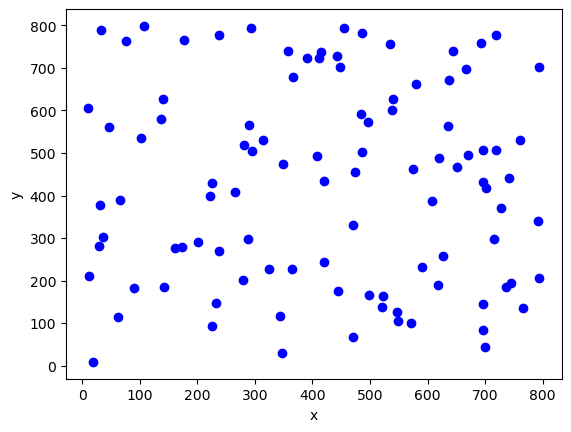

In [4]:
points_visualization(points).show()

## quadtree ##

budowa quadtree wizualizacja

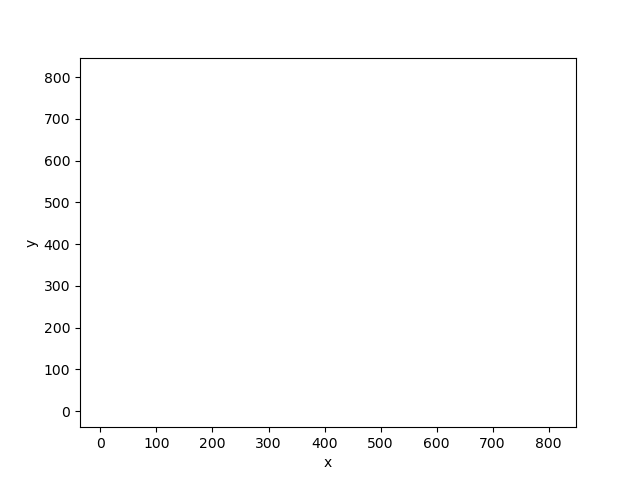

In [6]:

k = 4
vis= quadtree_vis(points, k)
vis.show_gif(interval=200)

działanie zapytania quadtree

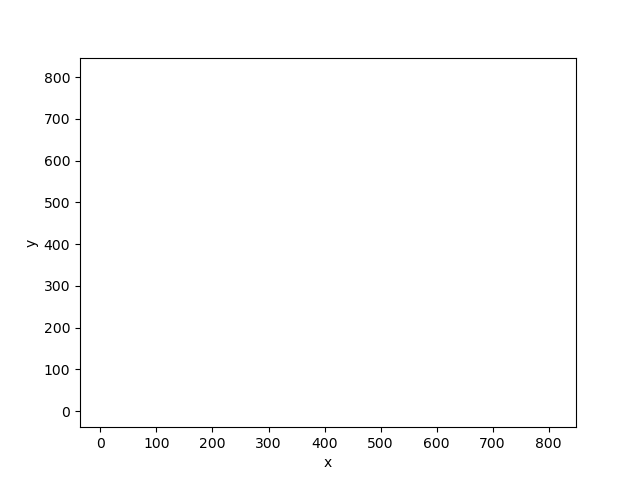

In [7]:

search_area = Rectangle(400, 350, 200, 150)
vis_query = visualize_quadtree_query(points, search_area, 4)
vis_query.show_gif(interval=200) 

## kd-tree ##

wizualizacja budowy kd-tree

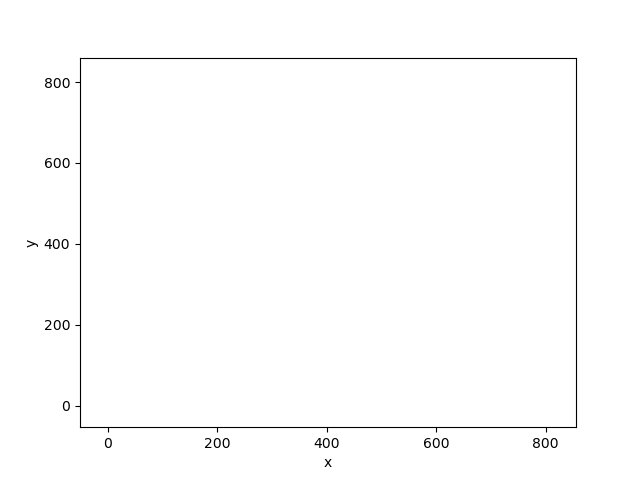

In [5]:
vis_kd = kd_build_visualization2(points)
vis_kd.show_gif()

działanie kd-tree wizualizacja

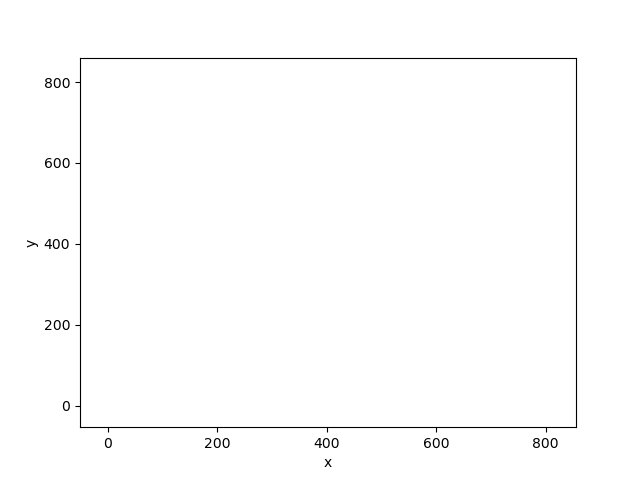

In [6]:
tree = KDTree(points)
query_box = (200, 600, 200, 500) # x_min, x_max, y_min, y_max
vis_kd2 = visualize_kdtree_query2(tree, points, query_box)
vis_kd2.show_gif(interval=150)

In [8]:
search_area = Rectangle(300, 300, 100, 100)

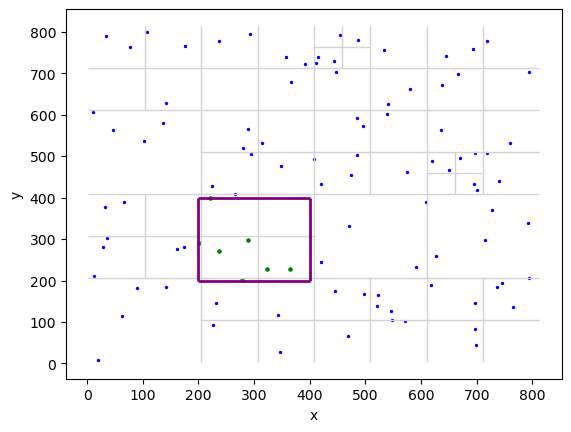

In [9]:
found_points = get_points_in_area("quadtree", points, search_area, 4)
vis4 = visualize_search_result(points, search_area, found_points, "quadtree")
vis4.show()

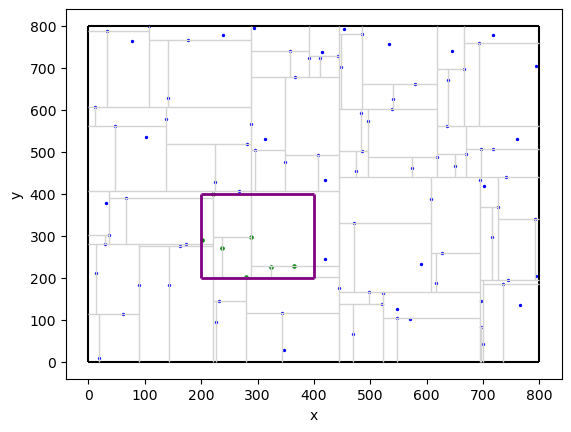

In [10]:
found_points = get_points_in_area("kdtree", points, search_area, 4)
vis5 = visualize_search_result(points, search_area, found_points, "kdtree")
vis5.show()

## Wizualizacja wyników algorytmów na przykładowych zbiorach danych

Poniżej przedstawimy wizualizacje zapytań na przykładzie zbiorów testowych, dla których będziemy potem porównywać czasy działania algorytmów

# Punkty losowane zgodnie z rozkładem jednostajnym

UNIFORM
Search rect: (200, 600, 250, 550)
Found QT: 88  sample: [(np.float64(232.49087373709142), np.float64(253.51649303878833)), (np.float64(220.85633857544468), np.float64(299.9574694550221)), (np.float64(281.1497770085654), np.float64(272.8238348572377)), (np.float64(298.9614915153905), np.float64(256.6283596573977)), (np.float64(309.29336729739066), np.float64(269.2677535258007)), (np.float64(309.0435071657604), np.float64(272.25716123109106)), (np.float64(342.5761481352484), np.float64(268.8738123702965)), (np.float64(300.4390292758171), np.float64(281.10731186815485)), (np.float64(316.4068947503262), np.float64(293.71093418816747)), (np.float64(377.02545978229676), np.float64(281.3965022059728)), (np.float64(367.2894172914589), np.float64(266.9486734586)), (np.float64(395.3607151639534), np.float64(271.36717703658934)), (np.float64(395.8321536902016), np.float64(295.850735432001)), (np.float64(294.7807355472343), np.float64(331.24401472213776)), (np.float64(214.3017100582848), n

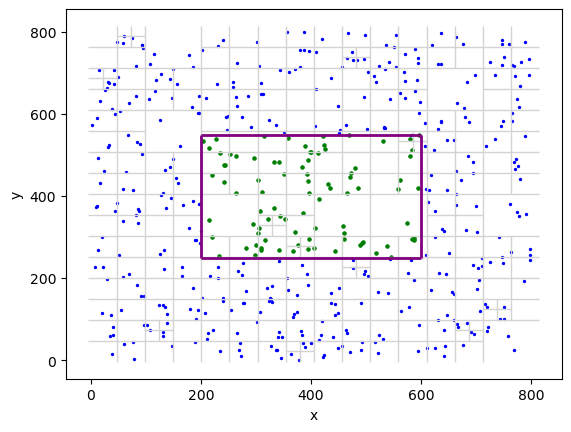

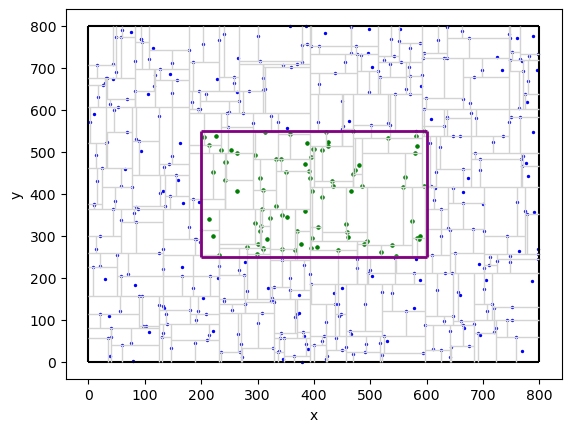

In [11]:
points = generate_uniform_points(0, 800, 500)
vis = points_visualization(points)
vis.save("images/uniform_set.png")
search_area = Rectangle(400, 400, 200, 150)

print("UNIFORM")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/uniform_result.png")




# Działanie na punktach wylosowanych zgodnie z rozkładem normalnym z przedziału [0, 800] x [0, 800]

NORMAL / GAUSS
Search rect: (320, 480, 320, 480)
Found QT: 253  sample: [(np.float64(344.952862693293), np.float64(324.99230146861464)), (np.float64(324.24681127905956), np.float64(346.9588488011095)), (np.float64(333.2690267263032), np.float64(343.1090842148799)), (np.float64(339.14893788803585), np.float64(330.11226091367496)), (np.float64(348.5703744720326), np.float64(347.0732723779961)), (np.float64(340.9913323656959), np.float64(336.42839796344714)), (np.float64(357.52003917281576), np.float64(322.6567508805157)), (np.float64(369.4429118994796), np.float64(321.39993739552585)), (np.float64(384.678139846384), np.float64(323.2793131244858)), (np.float64(386.46733253225966), np.float64(320.53875454244246)), (np.float64(395.9855176035295), np.float64(323.6848964655305)), (np.float64(360.98454683635015), np.float64(347.1450945779994)), (np.float64(364.0616329242134), np.float64(332.7157211974627)), (np.float64(383.0239102676175), np.float64(334.7535922530128)), (np.float64(390.0410141

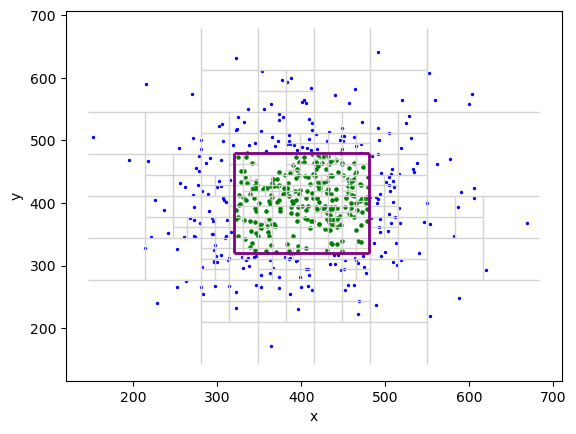

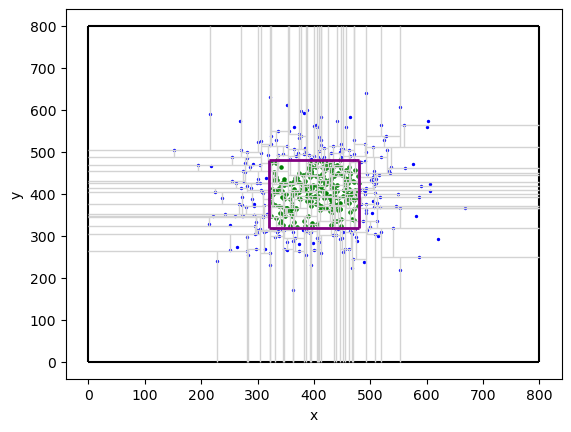

In [13]:
points = generate_normal_points(mean=400, std=80, n=500)
vis = points_visualization(points)
vis.save("images/normal_set.png")
search_area = Rectangle(400, 400, 80, 80)

print("NORMAL / GAUSS")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/normal_result.png")


CLUSTERS
Search rect: (120, 280, 520, 680)
Found QT: 120  sample: [(np.float64(183.35349192386138), np.float64(540.6604325939609)), (np.float64(188.275504719538), np.float64(540.6639147880536)), (np.float64(194.0802420731907), np.float64(541.0220704905104)), (np.float64(139.91074139106348), np.float64(554.9908551737134)), (np.float64(125.11856330996928), np.float64(569.381818770498)), (np.float64(127.87266977706868), np.float64(592.6535139312382)), (np.float64(163.8137566166247), np.float64(556.477554414702)), (np.float64(151.1397092100279), np.float64(569.7583004156534)), (np.float64(151.24928702850656), np.float64(570.1106422011483)), (np.float64(163.86609803021787), np.float64(564.1889970481124)), (np.float64(177.02036614015657), np.float64(561.6026314262384)), (np.float64(198.8273460338279), np.float64(555.2866189688016)), (np.float64(185.27311671288194), np.float64(574.2065974048212)), (np.float64(178.34232357990888), np.float64(567.7576514349053)), (np.float64(188.93591397851685)

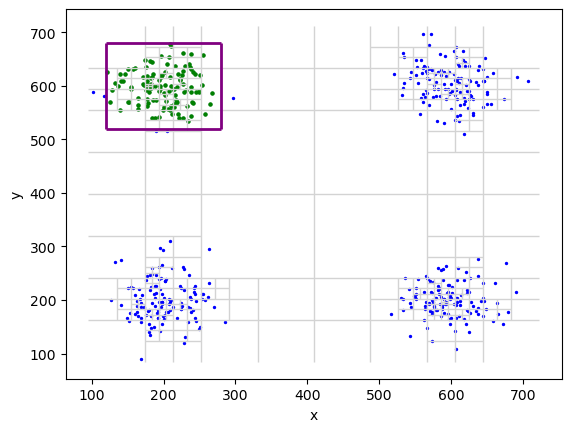

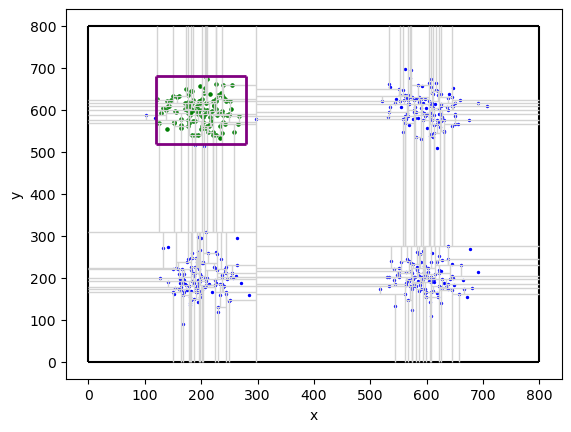

In [14]:
points = generate_clustered_points(
    cluster_centers=[(200, 200), (200, 600), (600, 200), (600, 600)],
    cluster_std=35,
    points_per_cluster=125
)
vis = points_visualization(points)
vis.save("images/clustered_set.png")
search_area = Rectangle(200, 600, 80, 80)  # celuję w klaster (200,600)

print("CLUSTERS")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/clustered_result.png")


COLLINEAR / DIAGONAL
Search rect: (300, 500, 300, 500)
Found QT: 68  sample: [(np.float64(304.94623123893643), np.float64(304.94623123893643)), (np.float64(301.8411745269484), np.float64(301.8411745269484)), (np.float64(305.427412731669), np.float64(305.427412731669)), (np.float64(306.52562384977796), np.float64(306.52562384977796)), (np.float64(312.0467078075384), np.float64(312.0467078075384)), (np.float64(309.6677234820813), np.float64(309.6677234820813)), (np.float64(311.3581402042893), np.float64(311.3581402042893)), (np.float64(310.0925038561826), np.float64(310.0925038561826)), (np.float64(313.35466682779173), np.float64(313.35466682779173)), (np.float64(320.3153386761661), np.float64(320.3153386761661)), (np.float64(321.97912706171314), np.float64(321.97912706171314)), (np.float64(328.16118513299716), np.float64(328.16118513299716)), (np.float64(325.8753393951938), np.float64(325.8753393951938)), (np.float64(338.038931767251), np.float64(338.038931767251)), (np.float64(338.9238

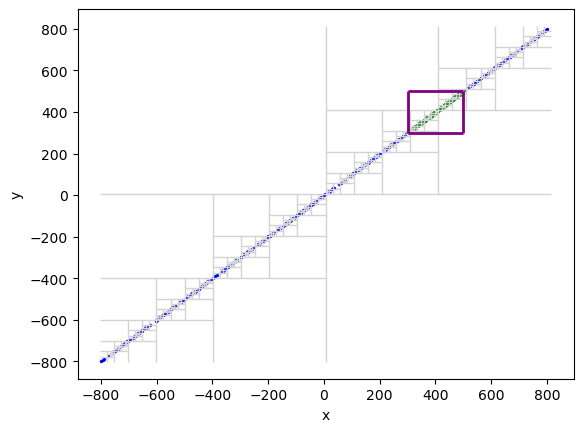

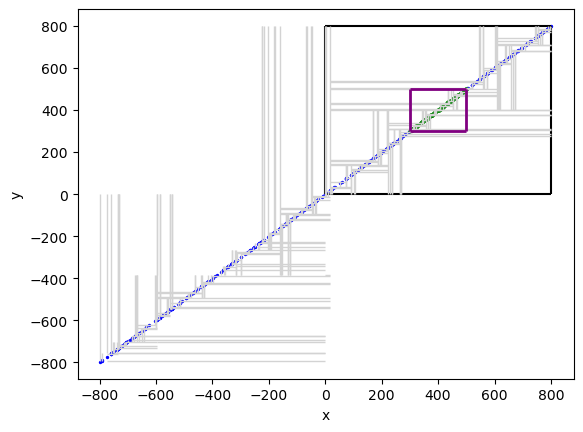

In [15]:
points = generate_collinear_points(a=(0,0), b=(800,800), n=500, x_range=800)  
vis = points_visualization(points)
vis.save("images/collinear_set.png")
search_area = Rectangle(400, 400, 100, 100)  # mały kwadrat przecinający prostą

print("COLLINEAR / DIAGONAL")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/collinear_result.png")


SQUARE + DIAGONALS
Search rect: (280, 520, 280, 520)
Found QT: 59  sample: [(np.float64(296.55456404490315), np.float64(296.55456404490315)), (np.float64(293.90038254170304), np.float64(293.90038254170304)), (np.float64(326.46821537456816), np.float64(326.46821537456816)), (np.float64(333.74852198458046), np.float64(333.74852198458046)), (np.float64(306.55296271132147), np.float64(306.55296271132147)), (np.float64(373.66295833543177), np.float64(373.66295833543177)), (np.float64(364.19755119487735), np.float64(364.19755119487735)), (np.float64(392.1566107862805), np.float64(392.1566107862805)), (np.float64(397.6253712390205), np.float64(397.6253712390205)), (np.float64(381.2066189424323), np.float64(381.2066189424323)), (np.float64(502.11570195431426), np.float64(297.88429804568574)), (np.float64(513.5981909918148), np.float64(286.4018090081852)), (np.float64(506.1524387332123), np.float64(293.8475612667877)), (np.float64(493.18328840796363), np.float64(306.81671159203637)), (np.float6

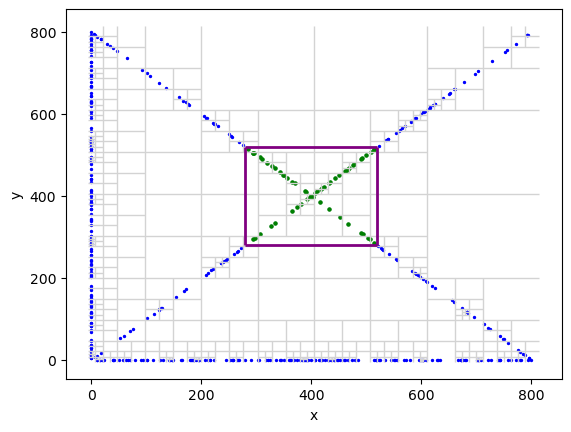

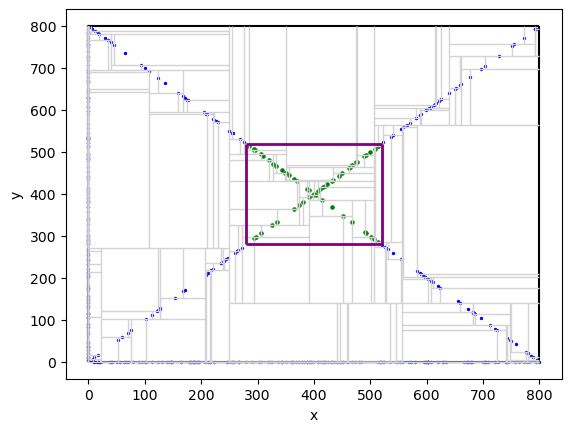

In [16]:
points = generate_square_points(
    a=(0, 0), b=(800, 0), c=(800, 800), d=(0, 800),
    axis_n=150, diag_n=100
)
vis = points_visualization(points)
vis.save("images/square_set.png")
search_area = Rectangle(400, 400, 120, 120)  # okolice przecięcia przekątnych

print("SQUARE + DIAGONALS")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/square_result.png")



GRID
Search rect: (80, 320, 80, 320)
Found QT: 36  sample: [(114.28571428571428, 114.28571428571428), (152.38095238095238, 114.28571428571428), (190.47619047619048, 114.28571428571428), (114.28571428571428, 190.47619047619048), (114.28571428571428, 152.38095238095238), (152.38095238095238, 152.38095238095238), (152.38095238095238, 190.47619047619048), (190.47619047619048, 152.38095238095238), (190.47619047619048, 190.47619047619048), (228.57142857142856, 114.28571428571428), (266.6666666666667, 114.28571428571428), (228.57142857142856, 190.47619047619048), (228.57142857142856, 152.38095238095238), (266.6666666666667, 152.38095238095238), (266.6666666666667, 190.47619047619048), (304.76190476190476, 114.28571428571428), (304.76190476190476, 190.47619047619048), (304.76190476190476, 152.38095238095238), (114.28571428571428, 228.57142857142856), (190.47619047619048, 228.57142857142856)]
Found KD: 36  sample: [(114.28571428571428, 114.28571428571428), (152.38095238095238, 114.2857142857142

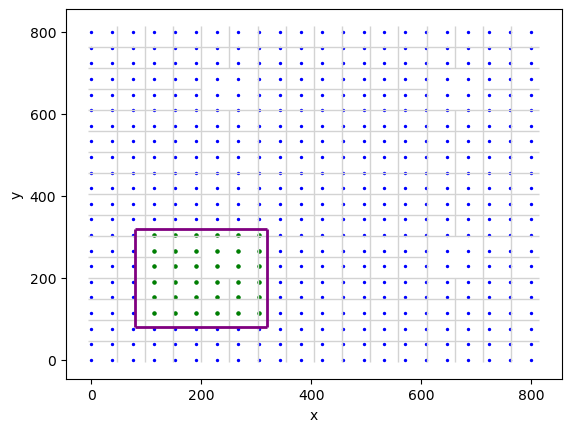

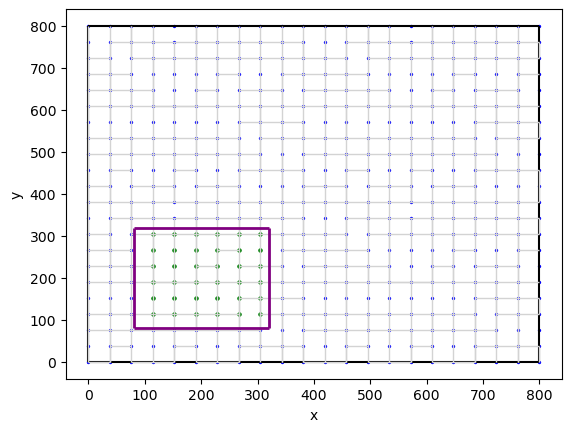

In [17]:
points = generate_grid_points(n=22)
scale = 800 / 21
points = [(i*scale, j*scale) for (i, j) in points]
vis= points_visualization(points)
vis.save("images/grid_set.png")
search_area = Rectangle(200, 200, 120, 120)

print("GRID")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/grid_result.png")


SPIRAL
Search rect: (470, 630, 280, 520)
Found QT: 57  sample: [(np.float64(519.2989251058707), np.float64(281.8224076007128)), (np.float64(518.7634631001973), np.float64(293.650149527116)), (np.float64(529.9298841293762), np.float64(294.9427761001621)), (np.float64(472.7313816235428), np.float64(361.1058670376269)), (np.float64(476.4800478531672), np.float64(363.92885019805215)), (np.float64(476.328630166902), np.float64(368.59456420384487)), (np.float64(477.34882200962795), np.float64(372.64131023589965)), (np.float64(482.21522449630083), np.float64(384.2844181762045)), (np.float64(481.06638910738434), np.float64(380.2270296679477)), (np.float64(480.80917914137), np.float64(375.92020092979374)), (np.float64(484.43912206822097), np.float64(392.5381284950931)), (np.float64(486.18730863755945), np.float64(387.98551870288327)), (np.float64(494.21999175957126), np.float64(396.43917789974665)), (np.float64(540.4051750437159), np.float64(317.9518638245702)), (np.float64(536.3400085247158), 

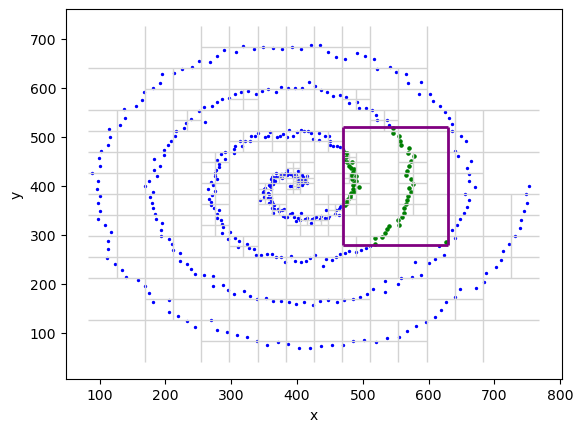

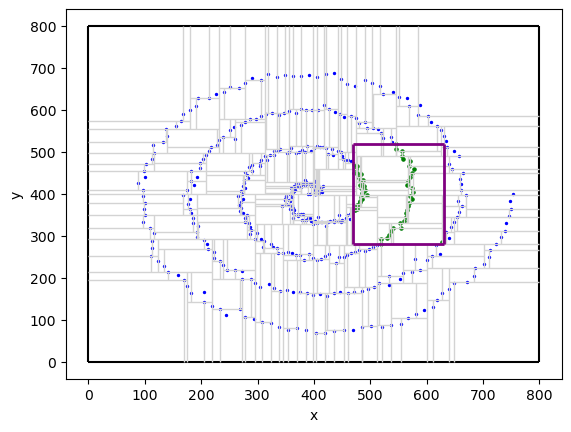

In [18]:
points = generate_spiral_points(n=500, center=(400, 400), max_radius=350, turns=4)
vi= points_visualization(points)
vi.save("images/spiral_set.png")
search_area = Rectangle(550, 400, 80, 120)  # pasek po prawej od środka

print("SPIRAL")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/spiral_result.png")


## Porównanie działania algorytmów ##

Chcemy teraz porównać działanie obydwu algorytmów na wybranych zbiorach testowych

In [ ]:
import time
import gc
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




N_VALUES = [1000, 5000, 10000, 25000, 50000, 100000, 200000]
REPEATS = 10  

def get_uniform(n): 
    return generate_uniform_points(0, 1000, n)

def get_normal(n): 
    return generate_normal_points(500, 50, n)

def get_clusters(n):
    centers = [(200, 200), (200, 800), (800, 200), (800, 800)]
    return generate_clustered_points(centers, 30, n // 4)

def get_diagonal(n):
    return generate_collinear_points((0,0), (1000,1000), n, x_range=1000)

def get_grid(n):
    side = int(np.sqrt(n))
    pts = generate_grid_points(side)
    scale = 1000 / max(side, 1)
    return [(p[0]*scale, p[1]*scale) for p in pts]

def get_spiral(n): 
    return generate_spiral_points(n, (500,500), 450, 5)

def get_square(n):
    # Dzielimy N na 4 części (2 osie, 2 przekątne)
    part = n // 4
    return generate_square_points((0,0), (1000,0), (1000,1000), (0,1000), part, part)

# Definicja scenariuszy testowych 
TEST_CASES = [
    {"name": "Uniform", "gen": get_uniform, "query": (400, 600, 400, 600)},
    {"name": "Normal (Gauss)", "gen": get_normal, "query": (480, 520, 480, 520)}, # Gęste centrum
    {"name": "Clusters", "gen": get_clusters, "query": (180, 220, 180, 220)},     # Jeden klaster
    {"name": "Diagonal", "gen": get_diagonal, "query": (450, 550, 450, 550)},     # Przecięcie linii
    {"name": "Grid", "gen": get_grid, "query": (100, 300, 100, 300)},             # Wycinek siatki
    {"name": "Spiral", "gen": get_spiral, "query": (550, 750, 450, 650)},         # Przecięcie ramion
    {"name": "Square + Diags", "gen": get_square, "query": (400, 600, 400, 600)}  # Centrum
]

print(f"🚀 ROZPOCZYNAM BENCHMARK (Incremental Method, Max N={max(N_VALUES)})...")
os.makedirs('data', exist_ok=True)
os.makedirs('plots', exist_ok=True)

for config in TEST_CASES:
    name = config["name"]
    gen_func = config["gen"]
    q_rect = config["query"] 
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("+", "plus")
    
    print(f"\ Zbiór: {name}")
    print(f"{'N':<8} | {'KD Build':<10} | {'QT Build':<10} | {'KD Query':<10} | {'QT Query':<10} | {'Found':<6}")
    print("-" * 75)

    
    try:
        master_data = gen_func(max(N_VALUES))
        random.shuffle(master_data) 
    except Exception as e:
        print(f"Błąd generatora: {e}")
        continue
        
    
    q_xmin, q_xmax, q_ymin, q_ymax = q_rect
    qw, qh = (q_xmax - q_xmin) / 2, (q_ymax - q_ymin) / 2
    qcx, qcy = q_xmin + qw, q_ymin + qh
    qt_query_obj = Rectangle(qcx, qcy, qw, qh)
    
    stats = []

    for n in N_VALUES:
       
        pts = master_data[:n]
        
        t_kd_build_sum = 0; t_qt_build_sum = 0
        t_kd_query_sum = 0; t_qt_query_sum = 0
        last_found = 0

        
        for _ in range(REPEATS):
            
           
            gc.disable()
            t0 = time.perf_counter()
            kd = KDTree(pts)
            t_kd_build_sum += (time.perf_counter() - t0)
            gc.enable()
            
       
            gc.disable()
            t0 = time.perf_counter()
            
            qt = build_quadtree(pts, capacity=10)
            t_qt_build_sum += (time.perf_counter() - t0)
            gc.enable()
            
           
            q_loops = 5
            t0 = time.perf_counter()
            for _ in range(q_loops):
                res = kd.query(q_rect)
            t_kd_query_sum += (time.perf_counter() - t0) / q_loops
            last_found = len(res)
            
            
            t0 = time.perf_counter()
            for _ in range(q_loops):
                res_qt = []
                qt.query(qt_query_obj, res_qt)
            t_qt_query_sum += (time.perf_counter() - t0) / q_loops

        
        avg_build_kd = t_kd_build_sum / REPEATS
        avg_build_qt = t_qt_build_sum / REPEATS
        avg_query_kd = t_kd_query_sum / REPEATS
        avg_query_qt = t_qt_query_sum / REPEATS
        
        print(f"{n:<8} | {avg_build_kd:.5f}s  | {avg_build_qt:.5f}s  | {avg_query_kd:.5f}s  | {avg_query_qt:.5f}s  | {last_found}")
        
        stats.append({
            "N": n, "Build_KD": avg_build_kd, "Build_QT": avg_build_qt,
            "Query_KD": avg_query_kd, "Query_QT": avg_query_qt, "Found": last_found
        })

    df = pd.DataFrame(stats)
    df.to_csv(f"data/{safe_name}.csv", index=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Wyniki: {name}", fontsize=14)
    
    ax1.plot(df["N"], df["Build_KD"], 'o-', label="KD-Tree")
    ax1.plot(df["N"], df["Build_QT"], 's--', label="QuadTree")
    ax1.set_title("Czas Budowy"); ax1.set_xlabel("N"); ax1.set_ylabel("s")
    ax1.legend(); ax1.grid(alpha=0.3)
    
    ax2.plot(df["N"], df["Query_KD"], 'o-', label="KD-Tree")
    ax2.plot(df["N"], df["Query_QT"], 's--', label="QuadTree")
    ax2.set_title(f"Czas Zapytania"); ax2.set_xlabel("N")
    ax2.legend(); ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"plots/{safe_name}.png")
    plt.close()


🚀 ROZPOCZYNAM BENCHMARK (Incremental Method, Max N=200000)...

📊 Zbiór: Uniform
N        | KD Build   | QT Build   | KD Query   | QT Query   | Found 
---------------------------------------------------------------------------
1000     | 0.00973s  | 0.01603s  | 0.00011s  | 0.00015s  | 40
5000     | 0.01858s  | 0.02167s  | 0.00016s  | 0.00033s  | 203
10000    | 0.05276s  | 0.06439s  | 0.00047s  | 0.00056s  | 405
25000    | 0.14911s  | 0.15925s  | 0.00162s  | 0.00063s  | 999
50000    | 0.38868s  | 0.47308s  | 0.00385s  | 0.00206s  | 1984
100000   | 0.94858s  | 1.07667s  | 0.00587s  | 0.00426s  | 4031
200000   | 2.53326s  | 2.88680s  | 0.01606s  | 0.01372s  | 8007

📊 Zbiór: Normal (Gauss)
N        | KD Build   | QT Build   | KD Query   | QT Query   | Found 
---------------------------------------------------------------------------
1000     | 0.01413s  | 0.01784s  | 0.00012s  | 0.00010s  | 114
5000     | 0.01911s  | 0.02331s  | 0.00043s  | 0.00032s  | 529
10000    | 0.05272s  | 0.06578s  |